# Plotting and Maps

In [9]:
# Import general libraries
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import glob
from shapely.geometry import Polygon, shape

# Import libraries for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.colors as mcolors

# Import raster libraries
import rasterio
import rasterio.warp
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling as ResamplingEnum
from rasterio.features import rasterize

## Set paths and variables

In [2]:
# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
downloaded_path = os.path.join(wd, r'Data\Downloaded')
derived_path = os.path.join(wd, r'Data\Derived')
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')
figure_path = os.path.join(wd, r'Figures')

# Set product paths
CONUS_path = os.path.join(wd, r'Data\Downloaded\CONUS_NoGreatLakes\CONUS_No_Great_Lakes.shp')
gmseusPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Arrays_instYr.shp')
CONUS_H3_path = os.path.join(downloaded_path, r'H3/res5_CONUS/CONUS_H3_maskClip.shp')
naipDateMap_folderPath = os.path.join(derived_path, r'NAIP_DateMap')

# Define the Albers Equal Area projection (EPSG: 5070 is commonly used for CONUS)
plotCRS = 'EPSG:5070'

## Helper Functions

In [10]:
# Create a function to merge raster files in a folder. This function will merge all TIFF files in a folder and reproject the merged raster to the specified CRS
def mergeRaster(folder_path, plotCRS, output_file):
    # Find all TIFF files in the folder
    tiff_files = glob.glob(os.path.join(folder_path, '*.tif'))
    
    # Open and read the TIFF files
    src_files_to_mosaic = []
    for tif_file in tiff_files:
        src = rasterio.open(tif_file)
        src_files_to_mosaic.append(src)
    
    # Merge the TIFF files into a single mosaic
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Get metadata of the first file to use for output metadata
    out_meta = src_files_to_mosaic[0].meta.copy()
    
    # Update the metadata with new dimensions, transform, and CRS
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": src_files_to_mosaic[0].crs
    })
    
    # Reproject the mosaic to the specified CRS
    dest_crs = plotCRS

    # Calculate the bounding box of the mosaic
    bounds = rasterio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], out_trans)

    # Calculate the transformation for reprojection
    transform, width, height = calculate_default_transform(
        src_files_to_mosaic[0].crs, dest_crs, mosaic.shape[2], mosaic.shape[1], *bounds)
    
    # Update metadata with the new CRS, width, and height
    out_meta.update({
        'crs': dest_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create a new raster to save the reprojected data
    with rasterio.open(output_file, "w", **out_meta) as dest:
        # Reproject the mosaic to the destination CRS
        for i in range(1, mosaic.shape[0] + 1):
            reproject(
                source=mosaic[i - 1],
                destination=rasterio.band(dest, i),
                src_transform=out_trans,
                src_crs=src_files_to_mosaic[0].crs,
                dst_transform=transform,
                dst_crs=dest_crs,
                resampling=ResamplingEnum.nearest)

    # Close all open source files
    for src in src_files_to_mosaic:
        src.close()

    print(f"Mosaic created and saved to {output_file}")

# Create a read raster function. This function will read a raster file and reproject it to the specified CRS
def readRaster(raster_path, plotCRS):
    # Open the raster file and reproject it to Albers Equal Area
    with rasterio.open(raster_path) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, plotCRS, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': plotCRS,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproject the raster
        raster = np.zeros((height, width), dtype=rasterio.float32)
        rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=raster,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=plotCRS,
            resampling=Resampling.nearest
        )

    return raster, kwargs

# Rasterize the CONUS_union boundary
def create_boundary_mask(geometry, raster_shape, transform):
    """
    Rasterize a geometry to match the raster dimensions.
    """
    boundary_mask = rasterize(
        [(geometry, 1)],  # Geometry to rasterize
        out_shape=raster_shape,  # Match raster dimensions
        transform=transform,  # Match raster transform
        fill=0,  # Background pixels (outside geometry)
        dtype='uint8'
    )
    return boundary_mask


## Get CONUS Shapes for Plots

In [15]:
# Load the shapefile and set CRS
conus = gpd.read_file(CONUS_path).set_crs(epsg=4269)
conus_albers = conus.to_crs(plotCRS)

# This is a complex shapefile with many small island polygons. Explode, remove polygons with area < 1 km^2, and dissolve by STATE attribute. 
conus_exploded = conus_albers.explode()
conus_exploded['areakm2'] = conus_exploded.area / 10**6
conus_exploded = conus_exploded[conus_exploded['areakm2'] >= 5]
conus_albers = conus_exploded.dissolve(by='STATE')

# Buffer  CONUS by 10 km and dissolve to create a single polygon. Return to a geodataframe
conus_union = conus_albers.buffer(500).unary_union
conus_union = gpd.GeoDataFrame(gpd.GeoSeries(conus_union), columns=['geometry'])

C:\Users\stidjaco\AppData\Local\Temp\ipykernel_28024\553193393.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  conus_exploded = conus_albers.explode()


# GM-SEUS Study Area and Results Plot

### New H3 Hex Plot

In [ ]:
# Load your data
CONUS = gpd.read_file(CONUS_path)
GMSEUS = gpd.read_file(gmseusPath)
CONUS_H3 = gpd.read_file(CONUS_H3_path)

# If using maskClip, dissolve H3 hexagons with the same GRID_ID
CONUS_H3 = CONUS_H3.dissolve(by='GRID_ID')

# Reset the index of the CONUS_H3 dataframe
CONUS_H3 = CONUS_H3.reset_index()

# Transform to plot CRS
CONUS = CONUS.set_crs(epsg=4269) # Native projection of US boundary - NAD83
CONUS = CONUS.to_crs(plotCRS)
GMSEUS = GMSEUS.to_crs(plotCRS)
CONUS_H3 = CONUS_H3.to_crs(plotCRS)

# Convert GMSEUS polygons to centroids
GMSEUS['centroid'] = GMSEUS.geometry.centroid
GMSEUS_centroids = GMSEUS.set_geometry('centroid')

# Add column to GMSEUS for counting
GMSEUS_centroids['num'] = 1

# Set GMSEUS_centroids area to km2
GMSEUS_centroids['area'] = GMSEUS_centroids['area'] / 10**6

# Select column to sum over
sumCol = 'num'

# Perform spatial join between CONUS_H3 and GMSEUS centroids
joined_gdf = gpd.sjoin(GMSEUS_centroids[[sumCol, 'centroid']], CONUS_H3[['GRID_ID', 'geometry']], how='inner', predicate='within')

# Calculate sum of 'num' for each GRID_ID
sum_per_hexagon = joined_gdf.groupby('GRID_ID')[sumCol].sum().reset_index()

# Merge the sum data back into CONUS_H3
CONUS_H3 = CONUS_H3.merge(sum_per_hexagon, on='GRID_ID', how='left')

# Fill NaN values with 0 if no points were found in a hexagon
CONUS_H3['sum'] = CONUS_H3[sumCol].fillna(0)

# Print count of CONUS_H3_GMSEUS with GRID_ID of yesID and noID
#yesID = '84279e7ffffffff' # Should half count of 1
#noID = '84279e5ffffffff' # Should have count of 0
#print(CONUS_H3[CONUS_H3['GRID_ID'] == yesID]['sum'])
#print(CONUS_H3[CONUS_H3['GRID_ID'] == noID]['sum'])

# Print sum of conus_h3 sum column
print(CONUS_H3['sum'].sum())

In [ ]:
# Set no-solar color -- other blues: darker: noSolarCol = '#060D32', lighter: noSolarCol = '#0B1844'
noSolarCol = '#09133C'

# Define a custom colormap: black for zero, then an orange-to-yellow gradient for 1 and above
cmap = mcolors.ListedColormap([noSolarCol] + plt.cm.YlOrBr(np.linspace(1, 0, 256)).tolist())

# Define color boundaries: 0 maps to black, 1-20 maps to the orange-yellow gradient
bounds = [0, 1] + list(range(2, 11))  # Ensures values from 1 and up use the orange-yellow gradient
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plotting with the custom colormap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
conus_union.plot(ax=ax, color='black', edgecolor='none', linewidth=0)
CONUS_H3.plot(column='sum', cmap=cmap, linewidth=0.0, ax=ax, edgecolor='none', legend=False, norm=norm, vmin=0, vmax=10)
CONUS.plot(ax=ax, color='none', edgecolor='white', linewidth=0.25)
conus_union.plot(ax=ax, color='none', edgecolor=noSolarCol, linewidth=0.25)

# Turn off the axis
ax.set_axis_off()

# Export to figures
plt.savefig(os.path.join(figure_path, 'GMSEUS_Arrays_Hex.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(figure_path, 'GMSEUS_Arrays_Hex.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)

# Close the plot
plt.close()


C:\Users\stidjaco\AppData\Local\Temp\ipykernel_9228\3327254275.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10000)     # Adjust as needed based on the data


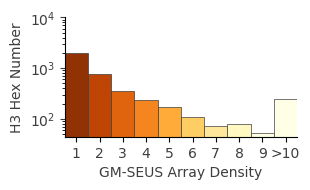

In [ ]:
# Assuming CONUS_H3 is already defined
# Categorize the 'sum' column into bins from 1 to 10 and a single bin for values above 10
CONUS_H3['sum_binned'] = pd.cut(CONUS_H3['sum'], bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')], right=False, labels=range(1, 11))

# Define custom colormap and normalization as specified
cmap = mcolors.ListedColormap(['black'] + plt.cm.YlOrBr(np.linspace(1, 0, 256)).tolist())
bounds = [0, 1] + list(range(2, 11))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the histogram with the custom colormap applied to each bin
fig, ax = plt.subplots(1, 1, figsize=(3, 1.55))
value_counts = CONUS_H3['sum_binned'].value_counts(sort=False)

# Color each bar individually based on its bin value using the colormap
for i, (bin_value, count) in enumerate(value_counts.items()):
    color = cmap(norm(bin_value))  # Get the color for the current bin value
    ax.bar(i, count, color=color, edgecolor='#3D3D3D', linewidth=0.5, width=1)


# Set y-axis to log scale
ax.set_yscale('log')

# Customize the axis labels and tick colors
ax.set_xlim(-0.5, 9.5)  # Limiting x-axis for bins from 1 to 10
ax.set_ylim(0, 10000)     # Adjust as needed based on the data
ax.set_ylabel('H3 Hex Count', color='#3D3D3D')
ax.set_xlabel('GM-SEUS Array Density', color='#3D3D3D')
ax.set_xticks(range(len(value_counts)))
ax.set_xticklabels([str(i) for i in range(1, 10)] + ['>10'], rotation=0, color='#3D3D3D')
ax.tick_params(axis='y', colors='#3D3D3D')  # Y-axis ticks color

# Turn off top and right axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.show()

# Export to figures
plt.savefig(os.path.join(figure_path, 'GMSEUS_Arrays_Hex_Histogram.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(figure_path, 'GMSEUS_Arrays_Hex_Histogram.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)


### Old Point Plot

In [82]:
# Call CONUS No Great Lakes
CONUS = gpd.read_file(CONUS_path)

# Call GM-SEUS Arrays
GMSEUS = gpd.read_file(gmseusPath)

# Transform GM-SEUS Arrays and CONUS to Albers Equal Area
GMSEUS = GMSEUS.to_crs(plotCRS)
CONUS = CONUS.set_crs(epsg=4269) # Native projection of US boundary - NAD83
CONUS = CONUS.to_crs(plotCRS)

# Get the centroid of the GM-SEUS arrays
GMSEUS['geometry'] = GMSEUS['geometry'].centroid

# Get area in km2
GMSEUS['area_km2'] = GMSEUS['area'] / 1e6

# Sort GM-SEUS arrays by 'area' in descending order so larger ones are plotted first
GMSEUS= GMSEUS.sort_values(by='area', ascending=False) 

# Import mlines
import matplotlib.lines as mlines

# Create a 7 in wide 5 in tall figure plot. 
fig, ax = plt.subplots(figsize=(9, 5))
CONUS.plot(ax=ax, color='black', edgecolor='white', linewidth=0.5)
GMSEUS.plot(ax=ax, color='orange', edgecolor='white', linewidth=0.05, alpha=0.5, 
            markersize = 1, marker = 'o') # markersize=GMSEUS['area_km2']*10 # Adjust marker size scaling factor

# Turn off the axis
ax.set_axis_off()

# Export to figures
plt.savefig(os.path.join(figure_path, 'GMSEUS_Arrays_Points.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(figure_path, 'GMSEUS_Arrays_Points.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)

# Close the plot
plt.close()

# NAIP Imagery Timestamp Map

## Prepare Raster (250m)

In [4]:
# Merge and Read rasters for 250m product
rasterInFolderPath = os.path.join(naipDateMap_folderPath, r'res250m\geeOutput')
rasterOutPath = os.path.join(naipDateMap_folderPath, r'res250m\naipMostRecentGEE.tif')
mergeRaster(rasterInFolderPath, plotCRS, rasterOutPath)

Mosaic created and saved to S:\Users\stidjaco\R_files\BigPanel\Data\Derived\NAIP_DateMap\res250m\naipMostRecentGEE.tif


## Read in raster and plot

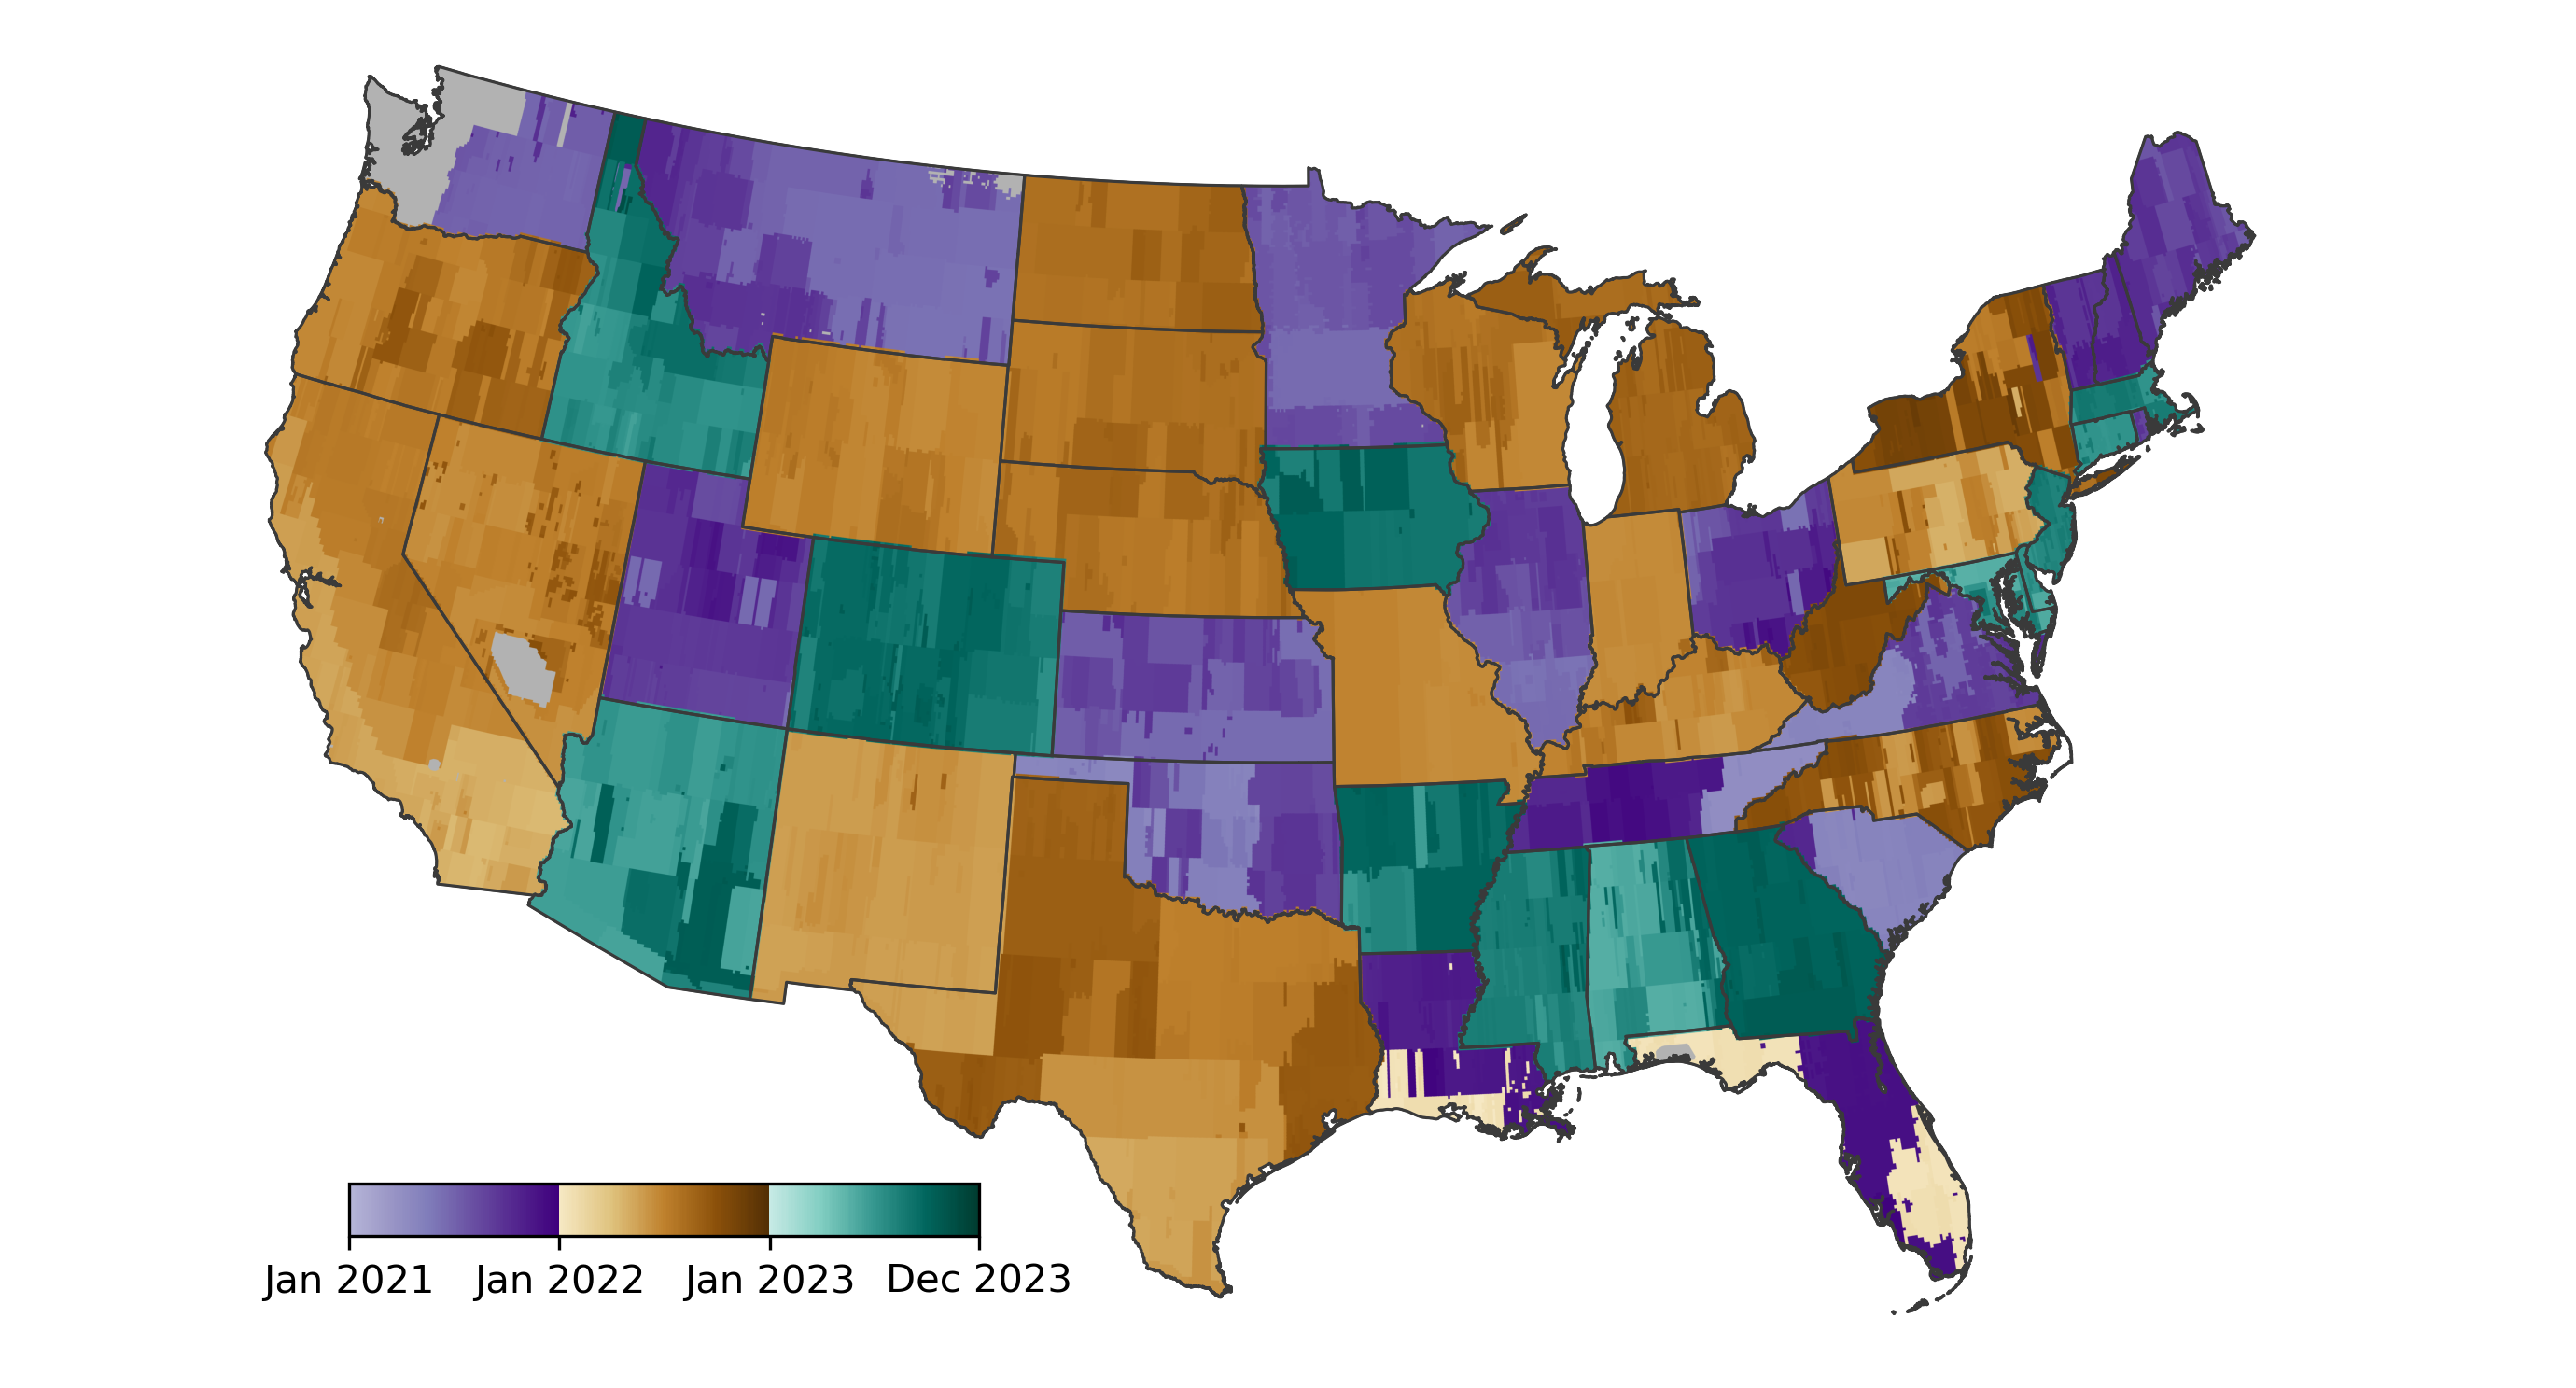

In [17]:
# ~~~~~~~~~ Open Raster File ~~~~~~~~~
inRaster = os.path.join(naipDateMap_folderPath, 'res250m/naipMostRecentGEE.tif')
raster, kwargs = readRaster(inRaster, plotCRS)

# ~~~~~~~~~ Define Time Ranges ~~~~~~~~~
start_2021 = datetime(2021, 1, 1).timestamp() * 1000
end_2021 = datetime(2021, 12, 31).timestamp() * 1000
start_2022 = datetime(2022, 1, 1).timestamp() * 1000
end_2022 = datetime(2022, 12, 31).timestamp() * 1000
start_2023 = datetime(2023, 1, 1).timestamp() * 1000
end_2023 = datetime(2023, 12, 31).timestamp() * 1000

# ~~~~~~~~~ Masks and Normalization ~~~~~~~~~
mask_2021 = (raster >= start_2021) & (raster <= end_2021)
mask_2022 = (raster >= start_2022) & (raster <= end_2022)
mask_2023 = (raster >= start_2023) & (raster <= end_2023)

raster_norm_2021 = (raster[mask_2021] - start_2021) / (end_2021 - start_2021)
raster_norm_2022 = (raster[mask_2022] - start_2022) / (end_2022 - start_2022)
raster_norm_2023 = (raster[mask_2023] - start_2023) / (end_2023 - start_2023)

# ~~~~~~~~~ Define Color Scales ~~~~~~~~~
# New color scale for 2021: Purple
cmap_purple = plt.colormaps['Purples']
purple_colors = cmap_purple(np.linspace(0.4, 1, 128))

# 2022 uses the original 2021 blue color scale
cmap_blue = plt.colormaps['BrBG']
blue_colors = cmap_blue(np.linspace(0, 0.4, 128))[::-1]  # Light to dark blue

# 2023 uses the original 2022 brown color scale
cmap_brown = plt.colormaps['BrBG']
brown_colors = cmap_brown(np.linspace(0.6, 1, 128))  # Light to dark brown

# ~~~~~~~~~ Apply Colormaps to Raster ~~~~~~~~~
colored_raster = np.zeros(raster.shape + (4,), dtype=np.float32)
colored_raster[mask_2021] = purple_colors[(raster_norm_2021 * 127).astype(int)]
colored_raster[mask_2022] = blue_colors[(raster_norm_2022 * 127).astype(int)]
colored_raster[mask_2023] = brown_colors[(raster_norm_2023 * 127).astype(int)]

# Create the boundary mask
boundary_mask = create_boundary_mask(conus_union.geometry[0], raster.shape, kwargs['transform'])

# Mask outside the CONUS_union geometry
mask_outside = (~((raster >= start_2021) & (raster <= end_2023)) | np.isnan(raster)) & (boundary_mask == 1)

# Apply grey only inside the CONUS boundary
grey_color = [0.7, 0.7, 0.7, 1.0]  # Light grey RGBA
colored_raster[mask_outside] = grey_color

# Set areas outside the CONUS boundary to transparent
colored_raster[boundary_mask == 0] = [0, 0, 0, 0]  # Fully transparent (RGBA)

# ~~~~~~~~~ Make the Plot ~~~~~~~~~
transform = kwargs['transform']
width, height = kwargs['width'], kwargs['height']

# Plotting with the custom colormap
fig, ax = plt.subplots(figsize=(9, 9), dpi=300)
ax.imshow(colored_raster, extent=(transform[2], transform[2] + transform[0] * width,
                                  transform[5] + transform[4] * height, transform[5]))
conus_albers.plot(ax=ax, color='none', edgecolor='#3A3A3A', linewidth=0.75)
conus_union.plot(ax=ax, color='none', edgecolor='#3A3A3A', linewidth=0.50)

# ~~~~~~~~~ Color Bar ~~~~~~~~~
combined_cmap = plt.cm.colors.ListedColormap(np.vstack((purple_colors, blue_colors, brown_colors)))
norm = Normalize(vmin=start_2021, vmax=end_2023)

# Add color bar
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=combined_cmap),
    ax=ax, orientation='horizontal', pad=-0.07, aspect=12, shrink=0.25, anchor=(0.17, 1.0))
tick_dates = [start_2021, start_2022, start_2023, end_2023]
tick_labels = ['Jan 2021', 'Jan 2022', 'Jan 2023', 'Dec 2023']
cbar.set_ticks(tick_dates)
cbar.set_ticklabels(tick_labels)

# ~~~~~~~~~ Finalize and Save Plot ~~~~~~~~~
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis('off')
plt.show()

# Save outputs
fig.savefig(os.path.join(figure_path, 'naipMostRecentGEE_ColorMap_2021to2023.png'), bbox_inches='tight', pad_inches=0.00)
fig.savefig(os.path.join(figure_path, 'naipMostRecentGEE_ColorMap_2021to2023.pdf'), bbox_inches='tight', pad_inches=0.00)

## Old NAIP imagery timestanmp map

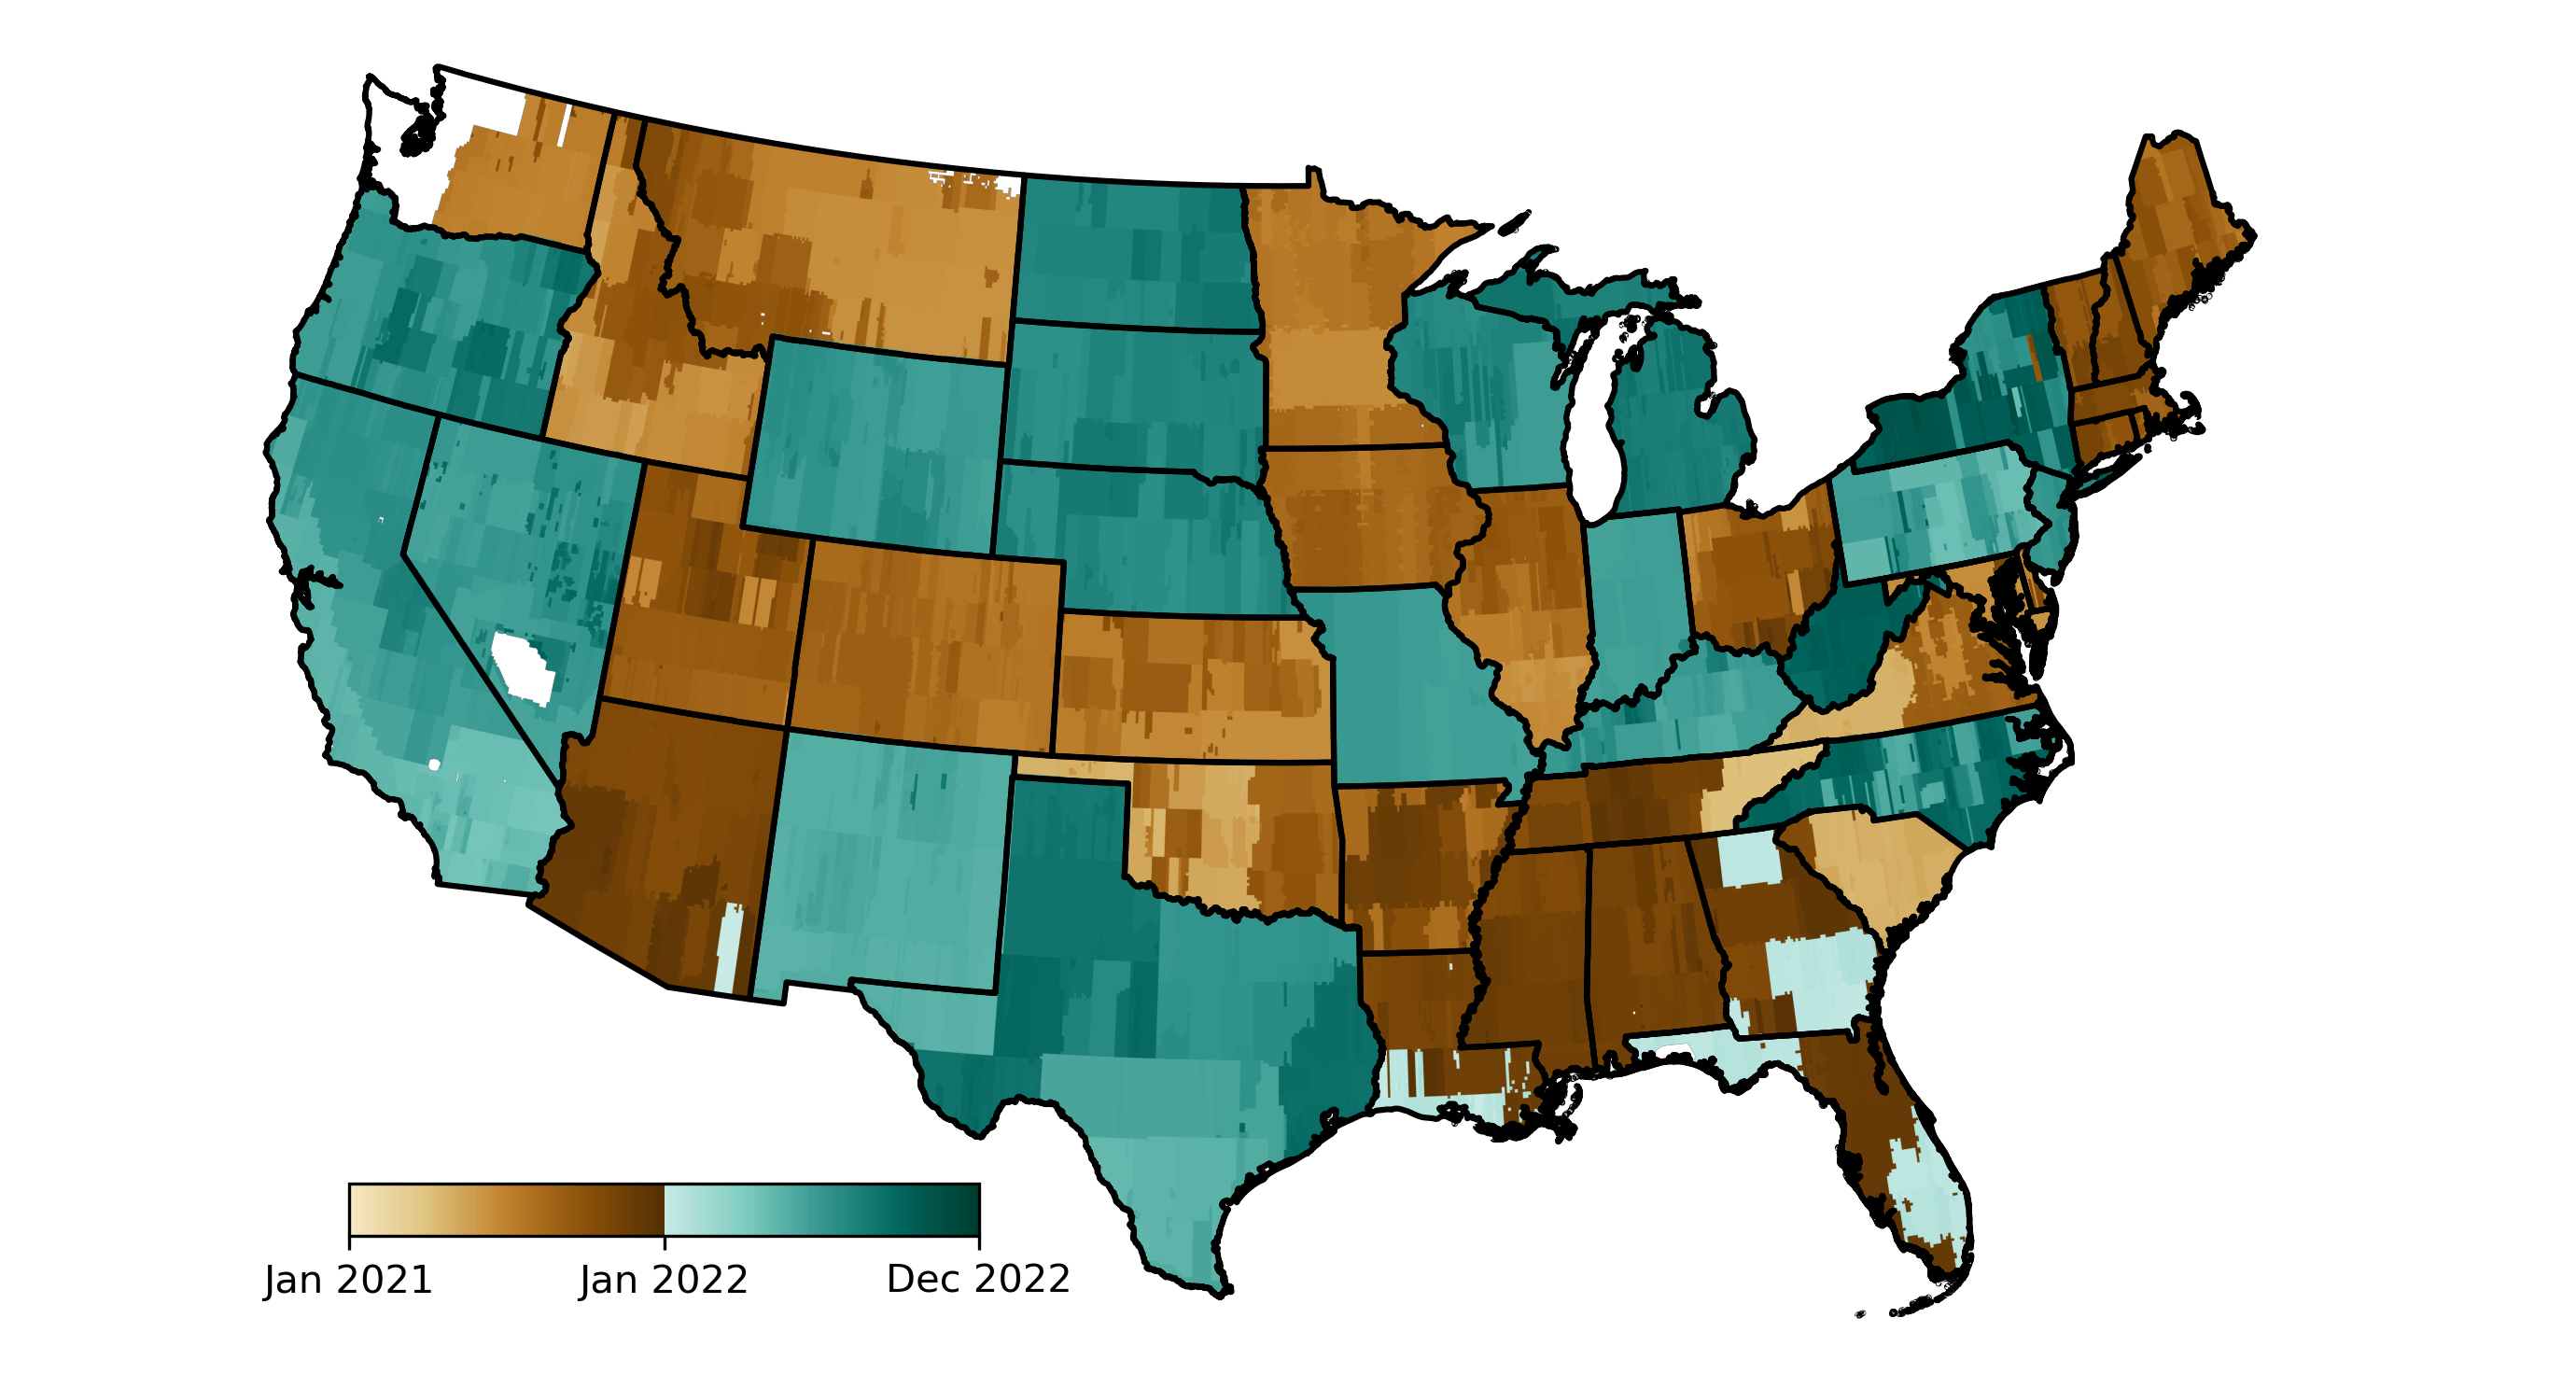

In [18]:
# Load the shapefile and set crs
conus = gpd.read_file(CONUS_path)
conus = conus.set_crs(epsg=4269) # Native projection of US boundary - NAD83

# Reproject the shapefile to Albers Equal Area
conus_albers = conus.to_crs(plotCRS)

# Open the raster file and read the data
inRaster = os.path.join(naipDateMap_folderPath, r'res250m\naipMostRecentGEE.tif')
raster, kwargs = readRaster(inRaster, plotCRS)

# Convert milliseconds to datetime and normalize to a range for color mapping
start_2021 = datetime(2021, 1, 1).timestamp() * 1000
end_2021 = datetime(2021, 12, 31).timestamp() * 1000
start_2022 = datetime(2022, 1, 1).timestamp() * 1000
end_2022 = datetime(2022, 12, 31).timestamp() * 1000

# Create a mask for 2021 and 2022
mask_2021 = (raster >= start_2021) & (raster <= end_2021)
mask_2022 = (raster >= start_2022) & (raster <= end_2022)

# Normalize the raster data within each year range
raster_norm_2021 = (raster[mask_2021] - start_2021) / (end_2021 - start_2021)
raster_norm_2022 = (raster[mask_2022] - start_2022) / (end_2022 - start_2022)

# Create separate colormaps for 2021 and 2022 using the BrBG colormap (matplotlib.colormaps[name])
cmap_brown = plt.colormaps['BrBG']
cmap_blue = plt.colormaps['BrBG']

# Create separate color arrays for 2021 and 2022
brown_colors = cmap_brown(np.linspace(0.60, 1, 128))  # Light to dark brown
blue_colors = cmap_blue(np.linspace(0, 0.40, 128))   # Light to dark blue

# Flip the blue colors to go from light to dark
blue_colors = blue_colors[::-1]

# Apply the colormap to the normalized data
colored_raster = np.zeros(raster.shape + (4,), dtype=np.float32)
colored_raster[mask_2021] = blue_colors[(raster_norm_2021 * 127).astype(int)]
colored_raster[mask_2022] = brown_colors[(raster_norm_2022 * 127).astype(int)]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Make the Plot

# Get transform and dimensions of the raster
transform = kwargs['transform']
width = kwargs['width']
height = kwargs['height']

# Plot the raster and shapefile. Make the figure 7in x 5in and 300 dpi
fig, ax = plt.subplots(figsize=(9, 9), dpi=300)
im = ax.imshow(colored_raster, extent=(transform[2], transform[2] + transform[0] * width, 
                                       transform[5] + transform[4] * height, transform[5]))
conus_albers.boundary.plot(ax=ax, color='black')

# Add a color bar
# Concatenate both colormaps for a single color bar. 
# Make it 50% of the original size. 
# Set the ticks and labels as follows: Jan 1st 2021, Jan 1st 2022, Dec 31st 2022 (extremes and middle of color bar)
combined_cmap = plt.cm.colors.ListedColormap(np.vstack((blue_colors, brown_colors)))
norm = Normalize(vmin=min(start_2021, start_2022), vmax=max(end_2021, end_2022))
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=combined_cmap), ax=ax, orientation='horizontal', pad=-0.07, aspect=12, shrink=0.25, anchor=(0.17, 1.0)) # fraction=0.025, aspect=12, 

# Set the tick positions and labels
tick_dates = [start_2021, start_2022, end_2022]
tick_labels = ['Jan 2021', 'Jan 2022', 'Dec 2022']
cbar.set_ticks(tick_dates)
cbar.set_ticklabels(tick_labels)

# Adjust layout to minimize padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Remove the axis and border
ax.axis('off')
plt.show()

# Save the plot
fig.savefig(os.path.join(figure_path, 'naipMostRecentGEE_ColorMap.png'), bbox_inches='tight', pad_inches=0.00)
fig.savefig(os.path.join(figure_path, 'naipMostRecentGEE_ColorMap.pdf'), bbox_inches='tight', pad_inches=0.00)

# Set light to dark brown for 2021 and light to dark blue for 2022
#cmap_brown = plt.cm.get_cmap('BrBG', 128)  # Browns
#cmap_blue = plt.cm.get_cmap('BrBG', 128)  # Blues
#brown_colors = cmap_brown(np.linspace(0.60, 1, 128))  # Light to dark brown
#blue_colors = cmap_blue(np.linspace(0, 0.40, 128))   # Light to dark blue